# Graficacion Meteorologica Mediante Interpolaciones 🌡

<img src=Imagenes/App2.jpg width=300px>
<h3>Intregrantes:</h3>
<h4>Juan Vargas <br>
Freddy Jaimes <br>
Angel de Leon</h4>
<hr>

<h2>Tomamos los datos consumiendo una api del clima</h2>
<h5>https://developer.weatherunlocked.com/documentation/localweather/forecast</h5>
<h3>Elegimos la locacion de Turquia Estambul</h3>
<img src=Imagenes/MemeTurco.jpg width=300px>
<hr>

## Consumo De Api para la Generacion de datos (1 Semana)

In [ ]:
#Importamos las librerias necesarias
using HTTP
using JSON

#Pido los datos desde la api
url = "http://api.weatherunlocked.com/api/forecast/41.01384,-28.94966?app_id=f8341b8f&app_key=380d876792d6ac1b32c5258c07c010a4"
res = HTTP.get(url)
json = JSON.parse(String(res.body))

Temperatura_max = []
Temperatura_min = []
temperatura = []
x = json["Days"]

for i in x
    push!(Temperatura_max, i["temp_max_c"])
    push!(Temperatura_min, i["temp_min_c"])
end

for i in 1:1:length(Temperatura_max)
    temp_max = Temperatura_max[i]
    temp_min = Temperatura_min[i]
    prom = temp_max + temp_min
    push!(temperatura, round(prom/2 , digits=2))
end
print(temperatura)
typeof(temperatura)


## Datos Meteorologicos anuales de Estambul

In [5]:
using HTTP
using JSON

api = "790e4819ffc841c5b1810355241106"
loc = "Istanbul"
doc = loc * "_weather_data.json"

data = []

for m in 1:12
    s_date = "2023-$(lpad(m, 2, '0'))-01"
    e_date = m != 12 ? "2023-$(lpad(m, 2, '0'))-31" : "2023-12-31"

    url = "http://api.worldweatheronline.com/premium/v1/past-weather.ashx?q=$(loc)&tp=24&date=$(s_date)&enddate=$(e_date)&format=json&key=$(api)"

    res = HTTP.get(url)

    if res.status == 200
        d = JSON.parse(String(res.body))
        push!(data, d)
        println("Datos del mes $m obtenidos correctamente")
    else
        println("Error al obtener datos del mes $m: $(res.status)")
    end
end

meses = [
    "Enero",
    "Febrero",
    "Marzo",
    "Abril",
    "Mayo",
    "Junio",
    "Julio",
    "Agosto",
    "Septiembre",
    "Octubre",
    "Noviembre",
    "Diciembre",
]

"""
for m_data in data
    m_max_t = []
    m_min_t = []
    m_avg_t = []

    for day in m_data["data"]["weather"]
        max_t = day["maxtempC"]
        min_t = day["mintempC"]
        avg_t = day["avgtempC"]

        push!(m_max_t, max_t)
        push!(m_min_t, min_t)
        push!(m_avg_t, avg_t)
    end

    push!(max_t, m_max_t)
    push!(min_t, m_min_t)
    push!(avg_t, m_avg_t)
end

"""

Datos del mes 1 obtenidos correctamente
Datos del mes 2 obtenidos correctamente
Datos del mes 3 obtenidos correctamente
Datos del mes 4 obtenidos correctamente
Datos del mes 5 obtenidos correctamente
Datos del mes 6 obtenidos correctamente
Datos del mes 7 obtenidos correctamente
Datos del mes 8 obtenidos correctamente
Datos del mes 9 obtenidos correctamente
Datos del mes 10 obtenidos correctamente
Datos del mes 11 obtenidos correctamente
Datos del mes 12 obtenidos correctamente


"for m_data in data\n    m_max_t = []\n    m_min_t = []\n    m_avg_t = []\n\n    for day in m_data[\"data\"][\"weather\"]\n        max_t = day[\"maxtempC\"]\n        min_t = day[\"mintempC\"]\n        avg_t = day[\"avgtempC\"]\n\n        push!(m_max_t, max_t)\n        push!(m_min_t, min_t)\n        push!(m_avg_t, avg_t)\n    end\n\n    push!(max_t, m_max_t)\n    push!(min_t, m_min_t)\n    push!(avg_t, m_avg_t)\nend\n\n"

<hr>

## Interpolacion de Taylor

Este es el polinomio de taylor: 1.0*x + (0.0447222222222222 - 0.0447222222222222*x)*(x - 6)*(x - 5)*(x - 4)*(x - 3)*(x - 2) + (0.2625 - 0.2625*x)*(x - 4)*(x - 3)*(x - 2) + (0.5 - 0.5*x)*(x - 2) + (0.125833333333333*x - 0.125833333333333)*(x - 5)*(x - 4)*(x - 3)*(x - 2) + (0.35*x - 0.35)*(x - 3)*(x - 2) + 21.0

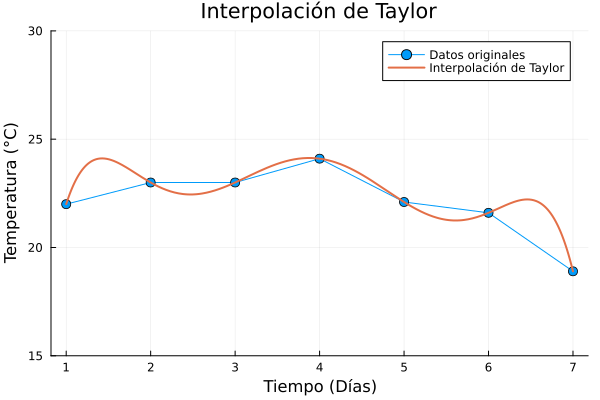

In [11]:
using SymPy
using Plots

temperatura = [22.0, 23.0, 23.0, 24.1, 22.1, 21.6, 18.9]
x = symbols("x")

function derivar(temperatura)
    copy_temp = [temperatura]
    for i in 1:length(temperatura)-1
        push!(copy_temp, diff(copy_temp[end]))
    end
    return copy_temp
end

function Interpolacion_Taylor(derivadas, x, x0)
    pol = derivadas[1][1]
    time = 1:length(derivadas)
    for i in 1:x0
        process = derivadas[i+1][1] / factorial(i)
        for j in 0:i-1
            process *= (x-time[j+1])
        end
        pol += process
    end
    return pol, time
end
    
polinomio, time = Interpolacion_Taylor(derivar(temperatura), x, length(temperatura)-1)

print("Este es el polinomio de taylor: $polinomio")
plot(time, temperatura, label="Datos originales", marker=:circle,  markersize=5)
plot!(polinomio, label="Interpolación de Taylor", linewidth=2)
ylims!(15,30)
xlabel!("Tiempo (Días)")
ylabel!("Temperatura (°C)")
title!("Interpolación de Taylor")

## Interpolacion de Lagrange

In [24]:
using Plots

días = [1, 2, 3, 4, 5, 6, 7]
temperaturas = [25.0, 24.5, 23.8, 22.5, 21.0, 20.2, 19.5]

function lagrange_interpolation(x, xi, yi)
    n = length(xi)
    m = length(x)
    L = zeros(n, m)
    for i in 1:n
        for j in 1:m
            L[i, j] = 1
            for k in 1:n
                if k!= i
                    L[i, j] = (x[j] - xi[k]) / (xi[i] - xi[k])
                end
            end
        end
    end
    return yi .* L
end

#Puntos para evaluar el polinomio interpolante
puntos_evaluación = range(1, 7, length=100)
temperaturas_interpoladas = lagrange_interpolation(puntos_evaluación, días, temperaturas)

#Graficar los resultados
plot(días, temperaturas, label="Datos originales", marker=:circle, legend=:topleft)
plot!(puntos_evaluación, temperaturas_interpoladas, label="Interpolación de Lagrange", linewidth=2)
xlabel!("Días")
ylabel!("Temperatura (°C)")
title!("Interpolación de Lagrange")


LoadError: Expects 100 elements in each col of y, found 7.

## Interpolacion por Trozos

1.0:0.06060606060606061:7.0


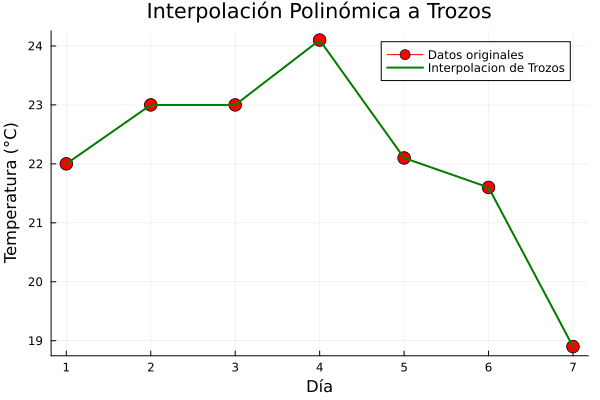

In [8]:
días = [1, 2, 3, 4, 5, 6, 7]

function porTrozos(x, xi, yi)
    i = searchsortedfirst(xi, x)
    if i == 1
        i = 2
    elseif i == length(xi) + 1
        i = length(xi)
    end
     x0, x1 = xi[i-1], xi[i]
    y0, y1 = yi[i-1], yi[i]
    m = (y1 - y0) / (x1 - x0)
    return y0 + m * (x - x0)
end

#Puntos para evaluar el spline
puntos_evaluación = range(1, 7, length=100)
temperaturas_spline = [porTrozos(x, días, temperatura) for x in puntos_evaluación]

println(puntos_evaluación)
#Graficar los resultados
plot(días, temperatura, label="Datos originales", marker=:circle, color="red", markersize=7)
plot!(puntos_evaluación, temperaturas_spline, label="Interpolacion de Trozos", color="green",lw=2)
xlabel!("Día")
ylabel!("Temperatura (°C)")
title!("Interpolación Polinómica a Trozos")

#prueba este que es el de por trozos



## Interpolación de Hermite

Datos de derivadas: [1.0, 0.5, 0.5500000000000007, -0.4499999999999993, -1.25, -1.6000000000000014, -2.700000000000003]


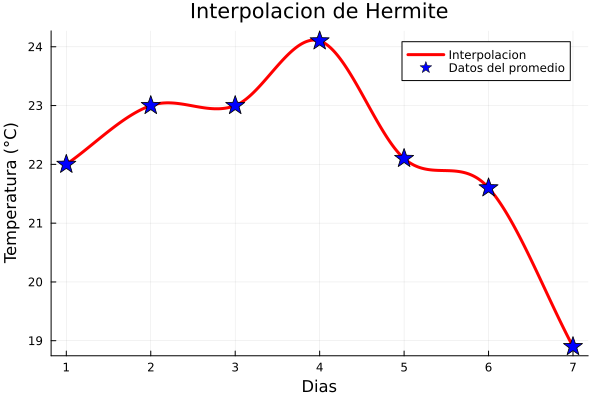

In [79]:
using PyCall
using Plots
np = pyimport("numpy")

function derivada(x, y)
    n = length(x) #cantidad de elementos de x
    dy = np.zeros(n)  #crea una array llena de ceros de tamano n

    dy[1] = (y[2] - y[1]) / (x[2] - x[1]) #se deriva el primer punto

    dy[end] = (y[end] - y[end-1]) / (x[end] - x[end-1]) # se deriva el ultimo punto

    for i in 2:n-1
        dy[i] = (y[i + 1] - y[i - 1]) / (x[i + 1] - x[i - 1]) # se derivan los puntos que estan desde la segunda posicion y la penultima
    end

    return dy
end


function buscarin(x_interp, x1, x2)
    indices = [] #se crea  el array indices
    for (i, val) in enumerate(x_interp) #i es el numero de veces que se hace la ciclo, mientras que val es el valor de xinter en la posición
        if x1 <= val <= x2 #si el valor de xinter esta entre los valores de x[i] y x[i+1]
            push!(indices, i) #crea un array indices y le agrega el valor i
        end
    end
    return indices
end



function interpolacionher(x, y, dy, xinter)
    n = length(x) #cantidad de elementos de x
    yinter = similar(xinter) #se crea un arreglo con el mismo tamano que xinter pero sin valores

    for i in 1:n-1 #hace un ciclo de 1 a n-1
        h = x[i + 1] - x[i] #se calcula el tamano de paso entre los puntos que te dan

        t = (xinter .- x[i]) / h #se calcula los valores normalizados para la interpolacion de Hermite

        h00 = 2 .* t.^3 .- 3 .* t.^2 .+ 1 #se utilizan estos valores para interpolar los valores de y y dy en los puntos xinter
        h10 = t.^3 .- 2 .* t.^2 .+ t
        h01 = -2 .* t.^3 .+ 3 .* t.^2
        h11 = t.^3 .- t.^2

        idx = buscarin(xinter, x[i], x[i + 1]) #se llama a la función buscari

        for j in idx # se hace un ciclo de los valores de indices
            yinter[j] = h00[j] * y[i] + h10[j] * h * dy[i] + h01[j] * y[i + 1] + h11[j] * h * dy[i + 1]
        end

    end
    return yinter
end

x = np.array(1:7)#crea un array de uno a siete
y = temperatura #se llama a la array temperatura como y


x = convert(Array{Float64}, x) #Convierte la array x a una array float si no lo era antes


dy = derivada(x, y)


xv = np.linspace(x[1], x[end], 1000) #genera mil puntos entre el primer elemento de x y el último para suavizar la lineas
yinterh = interpolacionher(x, y, dy, xv) #crea la interpolación de Hermite

println("Datos de derivadas: $dy")

plot(xv, yinterh, label="Interpolacion",color=:red , linewidth=3) 
scatter!(x, y, label="Datos del promedio", color=:blue, marker=:star, markersize=10)
plot!(title = "Interpolacion de Hermite", xlabel = "Dias", ylabel = "Temperatura (°C)")